# Introduction to Machine Learning Project
## Group: Medical Signal

# Importing Packages
---

In [3]:
!pip install -q neurokit2
!pip install -q wfdb
!pip install -q ecg-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 KB 4.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
from tensorflow import keras
import neurokit2 as nk
import wfdb
import ecg_plot
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from glob import glob
from pathlib import Path

# Loadind Dataset
---

In [5]:
# Mount GoogleDrive
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [6]:
# A sample of dataset records
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])
data

(array([[-0.2445, -0.229 ],
        [-0.2425, -0.2335],
        [-0.2415, -0.2345],
        ...,
        [ 0.152 ,  0.2695],
        [ 0.136 ,  0.256 ],
        [ 0.135 ,  0.2585]]),
 {'fs': 1000,
  'sig_len': 38400,
  'n_sig': 2,
  'base_date': None,
  'base_time': None,
  'units': ['mV', 'mV'],
  'sig_name': ['i', 'ii'],
  'comments': ['age: 81',
   'sex: female',
   'ECG date: 01/10/1990',
   'Diagnose:',
   'Reason for admission: Myocardial infarction',
   'Acute infarction (localization): infero-latera',
   'Former infarction (localization): no',
   'Additional diagnoses: Diabetes mellitus',
   'Smoker: no',
   'Number of coronary vessels involved: 1',
   'Infarction date (acute): 29-Sep-90',
   'Previous infarction (1) date: n/a',
   'Previous infarction (2) date: n/a',
   'Hemodynamics:',
   'Catheterization date: 16-Oct-90',
   'Ventriculography: Akinesia inferior wall',
   'Chest X-ray: Heart size upper limit of norm',
   'Peripheral blood Pressure (syst/diast):  140/80 mmHg',

In [7]:
from pathlib import Path 

root_path = Path("drive/MyDrive/ml-dataset/")

with open("drive/MyDrive/ml-dataset/RECORDS", "r")as f:
    records = [root_path / x.rstrip() for x in f.readlines()]

print(records)

[PosixPath('drive/MyDrive/ml-dataset/patient001/s0010_re'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0014lre'), PosixPath('drive/MyDrive/ml-dataset/patient001/s0016lre'), PosixPath('drive/MyDrive/ml-dataset/patient002/s0015lre'), PosixPath('drive/MyDrive/ml-dataset/patient003/s0017lre'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020are'), PosixPath('drive/MyDrive/ml-dataset/patient004/s0020bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021are'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0021bre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0025lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0031lre'), PosixPath('drive/MyDrive/ml-dataset/patient005/s0101lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0022lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0027lre'), PosixPath('drive/MyDrive/ml-dataset/patient006/s0064lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0026lre'), PosixPath('drive/MyDrive/ml-dataset/patient007/s0029lre

In [8]:
print(len(records))

549


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


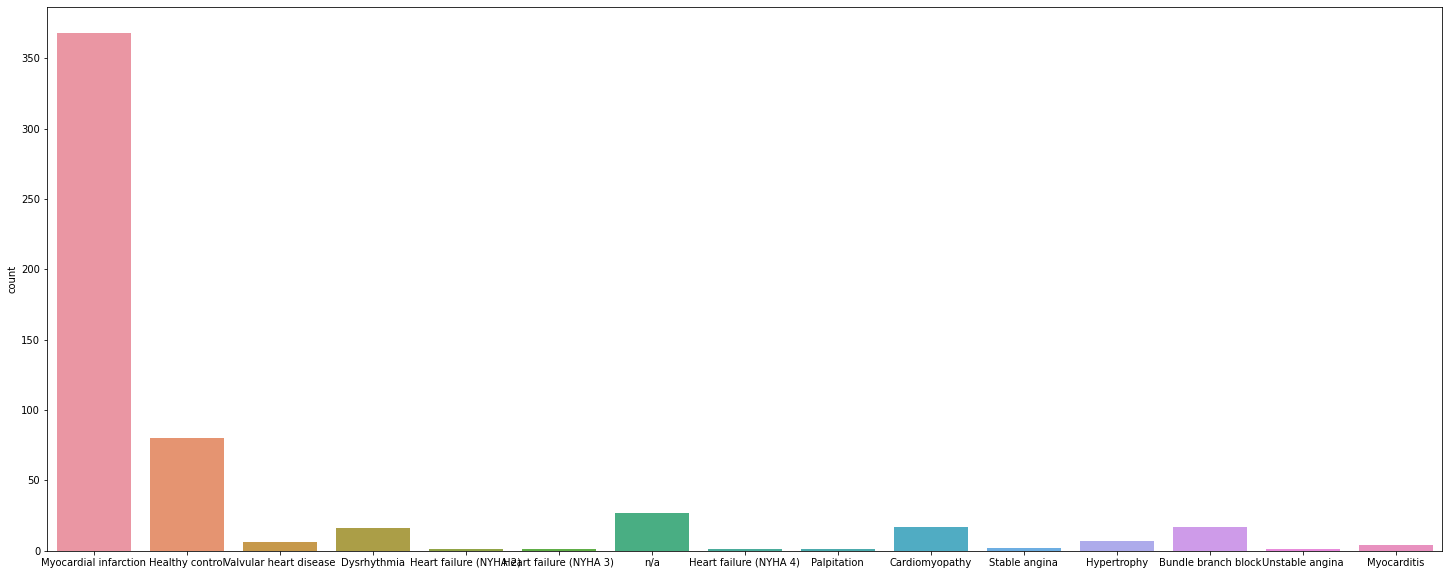

In [9]:
# Visualizing the distribution of classes
labels = []
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    labels.append(label)

plt.figure(figsize=(25, 10))
sns.countplot(labels)
plt.show()

Data Cleaning
---

In [10]:
# Removing data with n/a labels
for rec in records:
    data = wfdb.rdsamp(rec)
    label = " ".join(data[1]['comments'][4].split()[3:])
    if label == "n/a":
        records.remove(rec)

# Preprocessing
---

## Denoising

(38400, 2)


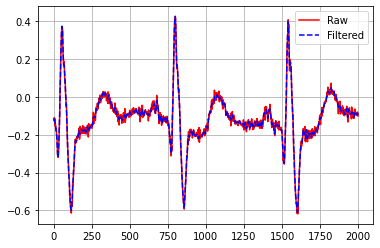

In [12]:
# IIR Filtering
def iir_lp(x, cutoff, fs):
    # sos = signal.butter(4, 2*cutoff/fs, output='sos')
    sos = signal.butter(5, cutoff,fs=fs, output='sos',analog=False,btype='low')
    y = signal.sosfiltfilt(sos, x.T)
    return y

data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re", channel_names=['i', 'ii'])[0]

print(data[:,1].shape)
plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(iir_lp(data[:, 0][5000:7000], 100, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])

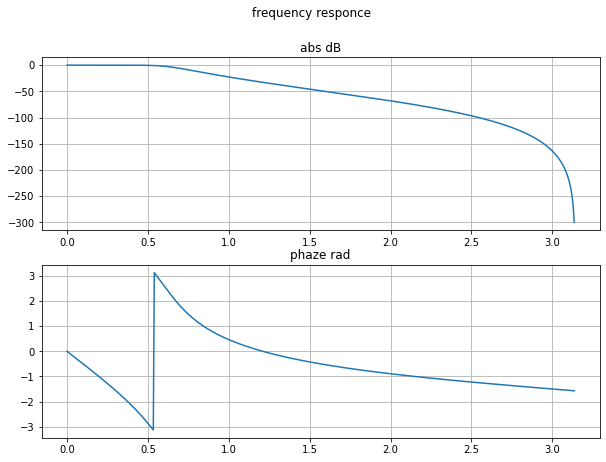

In [10]:
# Frequency response of IIR filter
b, a = signal.butter(5, 100,fs=1000, output='ba',analog=False,btype='low')
w, h = signal.freqz(b, a)
plt.figure(figsize = (10,7))
plt.subplot(2, 1, 1)
plt.plot(w, 20*np.log10(np.abs(h)))
plt.grid("on")
plt.title("abs dB")
plt.subplot(2, 1, 2)
plt.plot(w, np.angle(h))
plt.grid("on")
plt.title("phaze rad")
plt.suptitle("frequency responce")

plt.show()

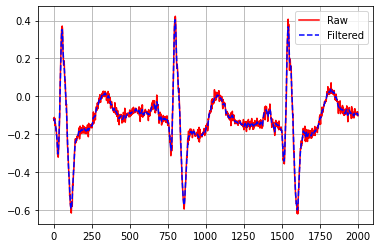

In [30]:
# FIR Filtering 
def fir_lp(x, cutoff, fs):
    h = signal.firwin(10, cutoff, fs=fs)
    y = signal.filtfilt(h, 1, x)
    return y

plt.plot(data[:, 0][5000:7000], 'r')
plt.plot(fir_lp(data[:, 0][5000:7000], 50, 1000), 'b--')
plt.grid("on")
plt.legend(["Raw", "Filtered"])
plt.show()

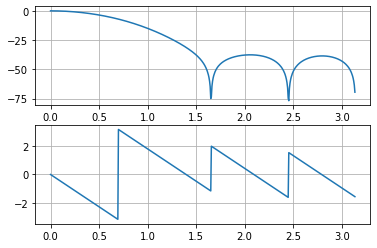

In [12]:
# Frequency response of FIR filter
h = signal.firwin(10, 50, fs=1000)
w, h = signal.freqz(h , 1)
fig, ax = plt.subplots(2, 1)
ax[0].plot(w, 20*np.log10(np.abs(h)))
ax[0].grid("on")
ax[1].plot(w, np.angle(h))
ax[1].grid("on")

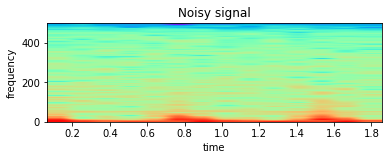

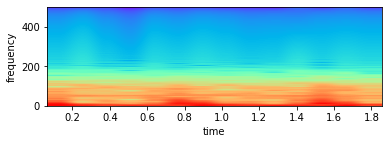

In [31]:
plt.subplot(2,1,1)
plt.specgram(data[:, 0][5000:7000], Fs=1000, cmap="rainbow")

# Set the title of the plot, xlabel and ylabel
# and display using show() function
plt.title('Noisy signal')
plt.ylabel("frequency")
plt.xlabel("time")
plt.show()
plt.subplot(2,1,2)
plt.specgram(iir_lp(data[:, 0][5000:7000], 100, 1000), Fs=1000, cmap="rainbow")

plt.ylabel("frequency")
plt.xlabel("time")
plt.show()

Dimensionality Reduction
---

In [14]:
# PCA
data = wfdb.rdsamp("drive/MyDrive/ml-dataset/patient001/s0010_re")[0]
pca = PCA(n_components=10)
pca_signal = pca.fit_transform(data)
print(f"Initial dimensions: {data.shape[1]} | Dimension after PCA: {pca_signal.shape[1]}")
print(data.shape,pca_signal.shape[1])

Initial dimensions: 15 | Dimension after PCA: 10
(38400, 15) 10


In [17]:
def preprocess(x):
    pca = PCA(n_components=10)
    x_pca = pca.fit_transform(x)
    x_filtered = iir_lp(x_pca, 50, 1000)
    return x_filtered



In [16]:
print(np.pad([[1,2],[3,4]],((2, 2),(1, 2)),'constant'))

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 2 0 0]
 [0 3 4 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


# Train
---

In [27]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, patients_list,
                 batch_size,
                 input_size=(10, 1000, 1),
                 shuffle=True):
        
        self.data_dir = data_dir
        self.patients_list = patients_list
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.patients_list)
        self.__get_recs()
    
    def __get_recs(self,):
        self.records = []
        for patient in self.patients_list:
            dir = Path(self.data_dir) / f"patient{str(patient).zfill(3)}"
            self.records.extend([dir / x[:-4] for x in  (f"{str(dir)}/*.dat")])
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.records)
    
    def __getitem__(self, index):
        rec = self.records[index]
        signals = preprocess(wfdb.rdsamp(rec)[0])
        if signals.shape[1] < self.batch_size*1000:
            np.pad(signals, ((0, 0),(0, self.batch_size*1000 - signals.shape[1])), 'constant')

        batched_signals = np.array([signals[:, i*1000:(i+1)*1000] for i in range(self.batch_size)])
        labels = " ".join(wfdb.rdsamp(rec)[1]['comments'][4].split()[3:])
        return (batched_signals.reshape(self.batch_size, *self.input_size),
                (np.array(labels) == 'Myocardial infarction').astype(int).repeat(self.batch_size))
    
    def __len__(self):
        return self.n

In [22]:
# Splitting data into train, test, validation over patients
NUM_SUBJECTS = 294
Sub_Range = np.arange(1, NUM_SUBJECTS+1)
train_patients = np.random.choice(Sub_Range, int(0.8*NUM_SUBJECTS), replace=False)
test_patients = np.array([idx for idx in Sub_Range if idx not in train_patients])

val_size=int(train_patients.shape[0]*0.8)
train_patients,valid_patients=train_patients[:val_size],train_patients[val_size:]
print("dimansion \n","train :",train_patients.shape[0],"\n valid :",valid_patients.shape[0],"\n test :",test_patients.shape[0])

train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
valid_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", valid_patients, 32)

test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 32)

dimansion 
 train : 188 
 valid : 47 
 test : 59


In [19]:
max_x=0
for x,y in train_gen :
  if max_x <np.max(x) :
    max_x=np.max(x)
print("max value in train data is : ",max_x)  

max value in test data is :  11.851231717272624


In [20]:
model = tf.keras.models.Sequential()
model.add(keras.layers.Rescaling(scale=1./15,  input_shape=(10, 1000, 1)))
model.add(keras.layers.Conv2D(32, 5, activation="relu", padding='same',strides=(1, 1)))
model.add(keras.layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 10, 1000, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 10, 1000, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 1000, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 500, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 500, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 500, 64)        36928     
                                                        

In [24]:
from keras.losses import BinaryCrossentropy

model.compile(optimizer='rmsprop', loss=BinaryCrossentropy(), metrics=['accuracy', 'Precision', 'Recall'])


In [22]:
model.fit(train_gen, validation_data=valid_gen,epochs=5)

Epoch 1/5
188/188 [==============================] - 123s 600ms/step - loss: 0.7225 - accuracy: 0.6963 - precision: 0.7023 - recall: 0.9848 - val_loss: 0.5912 - val_accuracy: 0.7234 - val_precision: 0.7234 - val_recall: 1.0000
Epoch 2/5
188/188 [==============================] - 112s 596ms/step - loss: 0.6653 - accuracy: 0.6809 - precision: 0.6809 - recall: 1.0000 - val_loss: 0.8057 - val_accuracy: 0.6170 - val_precision: 0.6170 - val_recall: 1.0000
Epoch 3/5
188/188 [==============================] - 109s 580ms/step - loss: 0.6782 - accuracy: 0.6968 - precision: 0.6968 - recall: 1.0000 - val_loss: 0.6746 - val_accuracy: 0.6170 - val_precision: 0.6170 - val_recall: 1.0000
Epoch 4/5
188/188 [==============================] - 109s 582ms/step - loss: 0.6702 - accuracy: 0.7074 - precision: 0.7112 - recall: 0.9925 - val_loss: 0.6466 - val_accuracy: 0.6383 - val_precision: 0.6383 - val_recall: 1.0000
Epoch 5/5
188/188 [==============================] - 111s 589ms/step - loss: 0.6756 - accura

In [23]:
model.evaluate(test_gen)

59/59 [==============================] - 28s 486ms/step - loss: 0.5083 - accuracy: 0.9153 - precision: 0.9153 - recall: 1.0000


[0.5082732439041138, 0.9152542352676392, 0.9152542352676392, 1.0]

# another *fold* validation 

In [35]:

val_size=int(train_patients.shape[0]*0.2)
train_patients,valid_patients=train_patients[val_size:],train_patients[:val_size]
print(train_patients.shape[0],valid_patients.shape[0],test_patients.shape[0])


train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32)
valid_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", valid_patients, 32)

model = tf.keras.models.Sequential()
model.add(keras.layers.Rescaling(scale=1./15,  input_shape=(10, 1000, 1)))
model.add(keras.layers.Conv2D(32, 5, activation="relu", padding='same',strides=(1, 1)))
model.add(keras.layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer='rmsprop', loss=BinaryCrossentropy(), metrics=['accuracy', 'Precision', 'Recall'])

model.fit(train_gen, validation_data=valid_gen,epochs=5)
model.evaluate(test_gen)

121 30 59
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 10, 1000, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 1000, 32)      832       
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 1000, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 500, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 5, 500, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 500, 64)        36928     
                                            

[0.6652208566665649, 0.6271186470985413, 0.6271186470985413, 1.0]

## try lower dimansion (feature selecting)

In [29]:
def preprocess(x):
    pca = PCA(3)
    x_pca = pca.fit_transform(x)
    x_filtered = iir_lp(x_pca, 50, 1000)
    return x_filtered


val_size=int(train_patients.shape[0]*0.8)
train_patients,valid_patients=train_patients[:val_size],train_patients[val_size:]
print(train_patients.shape[0],valid_patients.shape[0],test_patients.shape[0])

train_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", train_patients, 32,input_size=(3, 1000, 1))
valid_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", valid_patients, 32,input_size=(3, 1000, 1))
test_gen = DataGenerator("/content/drive/MyDrive/ml-dataset", test_patients, 32,input_size=(3, 1000, 1))

model = tf.keras.models.Sequential()
model.add(keras.layers.Rescaling(scale=1./15,  input_shape=(3, 1000, 1)))
model.add(keras.layers.Conv2D(32, 5, activation="relu", padding='same',strides=(1, 1)))
model.add(keras.layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.Conv2D(128, 3, activation="relu", padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=2, padding="same"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer='rmsprop', loss=BinaryCrossentropy(), metrics=['accuracy', 'Precision', 'Recall'])

model.fit(train_gen, validation_data=valid_gen,epochs=5)
model.evaluate(test_gen)


60 16 59
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 3, 1000, 1)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 3, 1000, 32)       832       
                                                                 
 conv2d_25 (Conv2D)          (None, 3, 1000, 32)       9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 2, 500, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 2, 500, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 2, 500, 64)        36928     
                                             

[0.44316568970680237, 1.0, 1.0, 1.0]